In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib as plt

# Поиск оптимальных параметров для моделей

В этом блокноте я постараюсь найти оптимальные параметры (с помощью optuna) для некоторых моделей детекции выбросов из библиотеки PyOD, чтобы позже построить их с оптимальными параметрами, проанализировать результаты и добиться максимальной интегральной точности с их помощью. 

## Загрузка и подготовка данных

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
X = df.drop(columns=['Time', 'Class'])
y = df.Class

In [4]:
norm = StandardScaler()
X_norm = pd.DataFrame(norm.fit_transform(X))

In [5]:
def get_data_part(X, y, size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, train_size=size, shuffle=True
    )
    print('train size: {}'.format(X_train.shape[0]))
    contamination = round(y_train.value_counts(normalize=True)[1], 3)
    print('contamination: {} ({}%)'.format(contamination, contamination * 100))
    return X_train, y_train, contamination

## Модели PyOD

In [6]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185348 sha256=24d9903b221d95a530085deb55282ea91949afffd74d3213499bedc9aeff76bc
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod
Note: you may need to restart the kernel to use updated packages.


In [7]:
from pyod.utils.data import evaluate_print

In [8]:
import optuna
from optuna.visualization.matplotlib import plot_param_importances, plot_parallel_coordinate
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay

In [9]:
def optimize(objective, n):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n, show_progress_bar=True)
    print('\nBest params:{}\nBest value:{}'.format(study.best_params, study.best_value))
    plot_param_importances(study)
    plot_parallel_coordinate(study)

In [10]:
def metrics(model, y_train):
    y_pred = model.labels_
    evaluate_print(model.__class__, y_train, y_pred)
    print(classification_report(y_train, y_pred))
    cm = confusion_matrix(y_train, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [11]:
np.random.seed(42)

### kNN Example

In [12]:
from pyod.models.knn import KNN

In [13]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.2);

train size: 56961
contamination: 0.002 (0.2%)


In [14]:
def objective(trial):
    clf = KNN(
        contamination=contamination,
        n_neighbors=trial.suggest_int('n', 50, 1000, log=True),
        method=trial.suggest_categorical('method', ['largest', 'mean', 'median']),
        radius=trial.suggest_float('radius', 0.5, 1),
        metric=trial.suggest_categorical('metric', ['l1', 'minkowski', 'l2'])
    )
    clf.fit(X_train)
    y_pred = clf.labels_
    return average_precision_score(y_train, y_pred)

[I 2023-08-01 21:39:24,089] A new study created in memory with name: no-name-7f9f3429-e97c-4acf-b138-a9a372a9d36a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-08-01 21:40:09,504] Trial 0 finished with value: 0.06002782463841514 and parameters: {'n': 119, 'method': 'mean', 'radius': 0.6130041746077828, 'metric': 'l2'}. Best is trial 0 with value: 0.06002782463841514.
[I 2023-08-01 21:40:20,611] Trial 1 finished with value: 0.06002782463841514 and parameters: {'n': 162, 'method': 'mean', 'radius': 0.6362126359251427, 'metric': 'minkowski'}. Best is trial 0 with value: 0.06002782463841514.
[I 2023-08-01 21:40:30,308] Trial 2 finished with value: 0.04342269637895923 and parameters: {'n': 51, 'method': 'largest', 'radius': 0.5809175399991349, 'metric': 'minkowski'}. Best is trial 0 with value: 0.06002782463841514.
[I 2023-08-01 21:41:13,421] Trial 3 finished with value: 0.03970566826580621 and parameters: {'n': 74, 'method': 'mean', 'radius': 0.5464414091152652, 'metric': 'l2'}. Best is trial 0 with value: 0.06002782463841514.
[I 2023-08-01 21:41:56,587] Trial 4 finished with value: 0.047313426072796635 and parameters: {'n': 108, 'method'

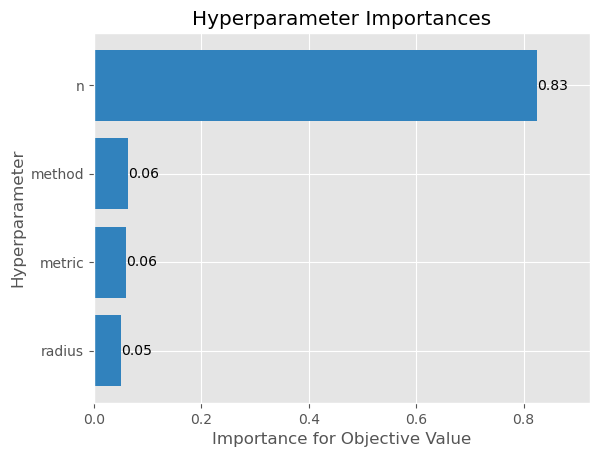

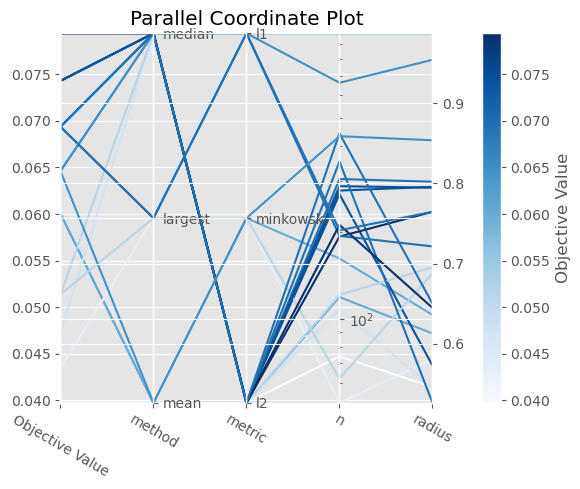

In [15]:
optimize(objective, 20)

### LOF
Local Outlier Factor

Is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

PyOD LOF is wrapper of scikit-learn LOF Class.

In [16]:
from pyod.models.lof import LOF

In [17]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.2)

train size: 56961
contamination: 0.002 (0.2%)


In [18]:
def objective(trial):
    clf = LOF(
        contamination=contamination,
        n_neighbors=trial.suggest_int('n_neighbors', 50, 1000, log=True),
        metric=trial.suggest_categorical('metric', ['l2', 'l1', 'minkowski'])
    )
    clf.fit(X_train)
    y_pred = clf.labels_
    return average_precision_score(y_train, y_pred)

[I 2023-08-01 21:53:50,774] A new study created in memory with name: no-name-b7e24516-005c-4bd1-bcb3-3dd21023f1cf


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2023-08-01 21:54:04,375] Trial 0 finished with value: 0.2180223253051037 and parameters: {'n_neighbors': 342, 'metric': 'minkowski'}. Best is trial 0 with value: 0.2180223253051037.
[I 2023-08-01 21:55:20,160] Trial 1 finished with value: 0.1136997559349618 and parameters: {'n_neighbors': 948, 'metric': 'l1'}. Best is trial 0 with value: 0.2180223253051037.
[I 2023-08-01 21:56:27,551] Trial 2 finished with value: 0.2180223253051037 and parameters: {'n_neighbors': 250, 'metric': 'l1'}. Best is trial 0 with value: 0.2180223253051037.
[I 2023-08-01 21:57:33,053] Trial 3 finished with value: 0.0017731430276856095 and parameters: {'n_neighbors': 68, 'metric': 'l1'}. Best is trial 0 with value: 0.2180223253051037.
[I 2023-08-01 21:57:43,378] Trial 4 finished with value: 0.047313426072796635 and parameters: {'n_neighbors': 101, 'metric': 'minkowski'}. Best is trial 0 with value: 0.2180223253051037.
[I 2023-08-01 21:58:48,715] Trial 5 finished with value: 0.0017731430276856095 and parameter

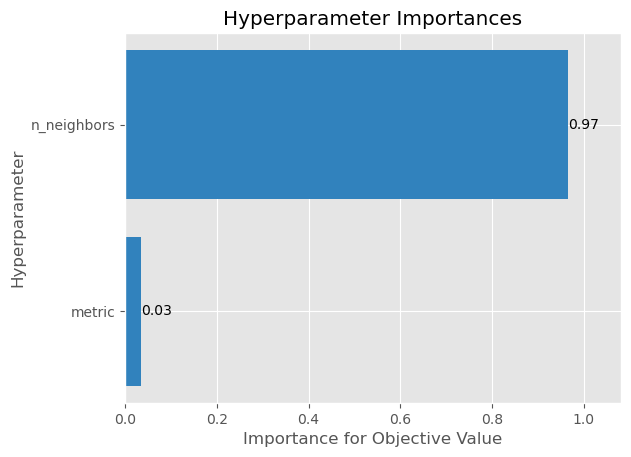

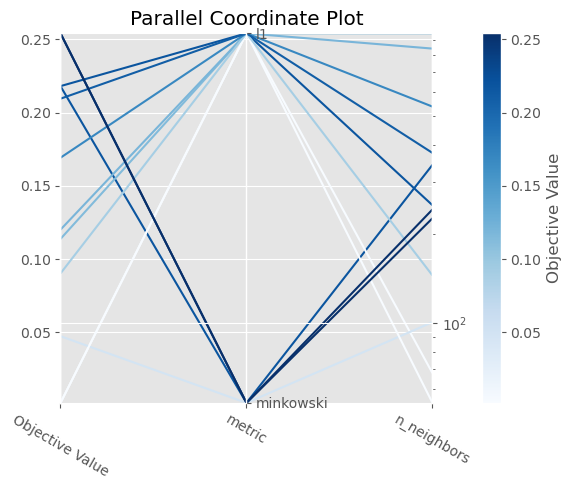

In [19]:
optimize(objective, 12)

In [20]:
# %%time
# clf = LOF(contamination=contamination, n_neighbors=280, metric='l1')
# clf.fit(X_train)

In [21]:
# metrics(clf, y_train)

### Isolation Forest

IsolationForest Outlier Detector. Implemented on scikit-learn library.

In [22]:
from pyod.models.iforest import IForest

In [23]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.3)

train size: 85442
contamination: 0.002 (0.2%)


In [24]:
def objective(trial):
    clf = IForest(
        contamination=contamination,
        random_state=0,
        n_estimators=trial.suggest_int('n', 50, 1000, log=True)
    )
    clf.fit(X_train)
    y_pred = clf.labels_
    return average_precision_score(y_train, y_pred)

[I 2023-08-01 22:03:55,394] A new study created in memory with name: no-name-5989eaf6-ef8b-4b71-bc54-560f75eff0fa


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-01 22:04:03,982] Trial 0 finished with value: 0.05584963670675087 and parameters: {'n': 158}. Best is trial 0 with value: 0.05584963670675087.
[I 2023-08-01 22:04:15,285] Trial 1 finished with value: 0.07434194900213309 and parameters: {'n': 209}. Best is trial 1 with value: 0.07434194900213309.
[I 2023-08-01 22:04:19,418] Trial 2 finished with value: 0.08460678087138619 and parameters: {'n': 78}. Best is trial 2 with value: 0.08460678087138619.
[I 2023-08-01 22:04:47,775] Trial 3 finished with value: 0.08110971278744537 and parameters: {'n': 525}. Best is trial 2 with value: 0.08460678087138619.
[I 2023-08-01 22:04:57,651] Trial 4 finished with value: 0.07434194900213309 and parameters: {'n': 183}. Best is trial 2 with value: 0.08460678087138619.
[I 2023-08-01 22:05:32,791] Trial 5 finished with value: 0.07434194900213309 and parameters: {'n': 651}. Best is trial 2 with value: 0.08460678087138619.
[I 2023-08-01 22:05:42,158] Trial 6 finished with value: 0.064756234280588 an

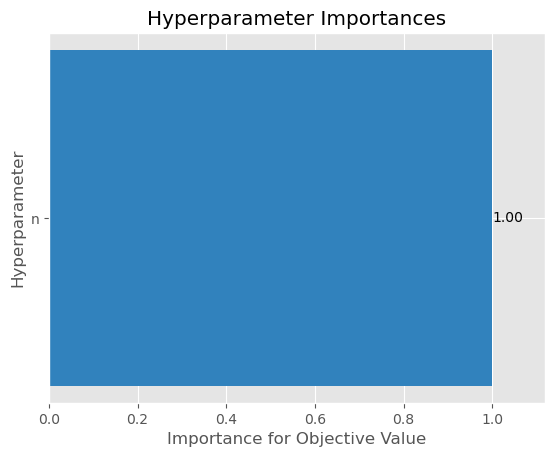

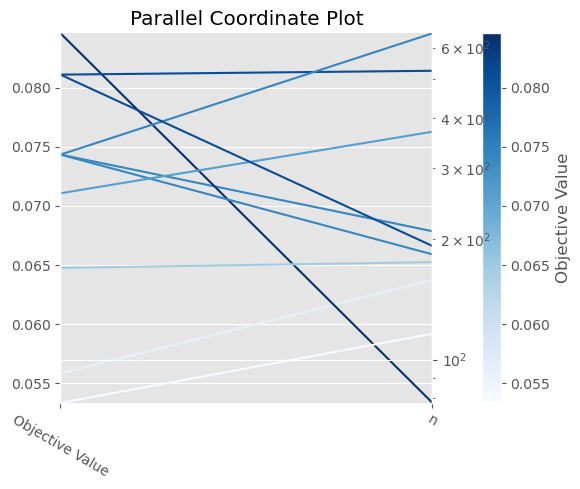

In [25]:
optimize(objective, 10)

### HBOS

Histogram- based outlier detection (HBOS) is an efficient unsupervised method. It assumes the feature independence and calculates the degree of outlyingness by building histograms

In [26]:
from pyod.models.hbos import HBOS

In [27]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.3)

train size: 85442
contamination: 0.002 (0.2%)


In [28]:
def objective(trial):
    clf = HBOS(
        contamination=contamination,
        n_bins='auto',
        alpha=trial.suggest_float('alpha', 0.05, 0.2),
        tol=trial.suggest_float('tol', 0.05, 0.9, log=True)
    )
    clf.fit(X_train)
    y_pred = clf.labels_
    return average_precision_score(y_train, y_pred)

[I 2023-08-01 22:06:20,403] A new study created in memory with name: no-name-1888a0da-dc77-4cdc-aa4c-fc2402c81724


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2023-08-01 22:06:52,296] Trial 0 finished with value: 0.10717379605301629 and parameters: {'alpha': 0.05263097768762644, 'tol': 0.08671768089534437}. Best is trial 0 with value: 0.10717379605301629.
[I 2023-08-01 22:07:24,150] Trial 1 finished with value: 0.09555072988834724 and parameters: {'alpha': 0.12004680128741642, 'tol': 0.2588313795027087}. Best is trial 0 with value: 0.10717379605301629.
[I 2023-08-01 22:07:55,833] Trial 2 finished with value: 0.09555072988834724 and parameters: {'alpha': 0.09836618395434193, 'tol': 0.09736180552577071}. Best is trial 0 with value: 0.10717379605301629.
[I 2023-08-01 22:08:27,770] Trial 3 finished with value: 0.09934962781571383 and parameters: {'alpha': 0.08596855228839013, 'tol': 0.5964515020026282}. Best is trial 0 with value: 0.10717379605301629.
[I 2023-08-01 22:08:59,587] Trial 4 finished with value: 0.09555072988834724 and parameters: {'alpha': 0.19398636446688527, 'tol': 0.08048424653195288}. Best is trial 0 with value: 0.10717379605

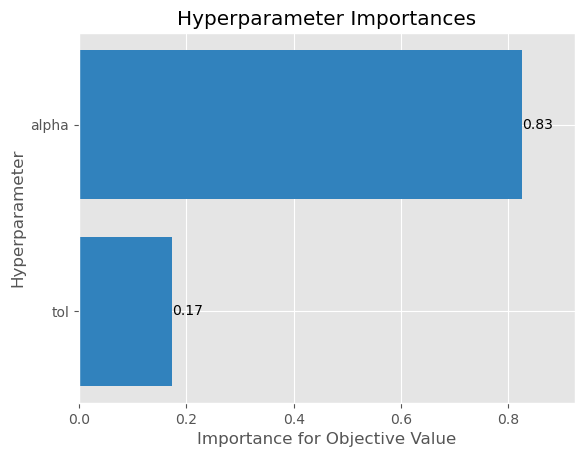

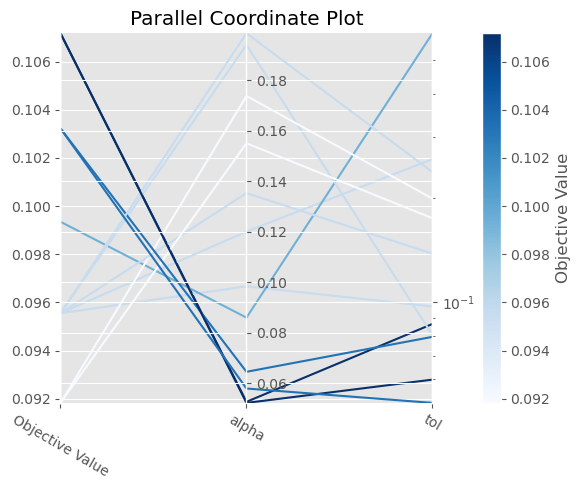

In [29]:
optimize(objective, 12)

### Parameter-free models

* Unsupervised Outlier Detection Using Empirical Cumulative Distribution Functions (ECOD)
* Rotation-based Outlier Detector (ROD)
* Copula Based Outlier Detector (COPOD)

In [30]:
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from pyod.models.rod import ROD

In [31]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.8)

train size: 227845
contamination: 0.002 (0.2%)


<class 'pyod.models.ecod.ECOD'> ROC:0.6668, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.29      0.34      0.31       391

    accuracy                           1.00    227845
   macro avg       0.64      0.67      0.65    227845
weighted avg       1.00      1.00      1.00    227845

[[227129    325]
 [   260    131]]
CPU times: user 4.72 s, sys: 288 ms, total: 5 s
Wall time: 5.23 s


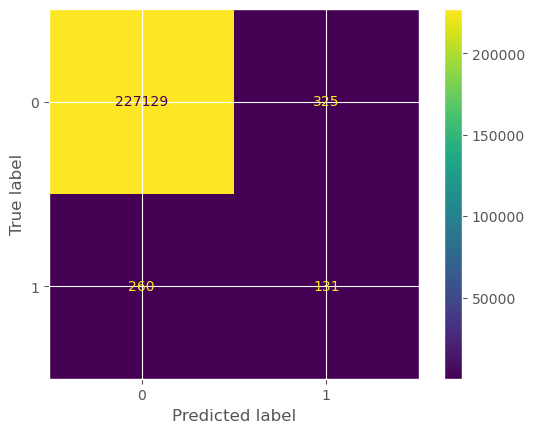

In [32]:
%%time
ecod = ECOD(contamination=contamination)
ecod.fit(X_train)
metrics(ecod, y_train)

<class 'pyod.models.copod.COPOD'> ROC:0.6988, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.34      0.40      0.37       391

    accuracy                           1.00    227845
   macro avg       0.67      0.70      0.68    227845
weighted avg       1.00      1.00      1.00    227845

[[227154    300]
 [   235    156]]
CPU times: user 3.49 s, sys: 264 ms, total: 3.76 s
Wall time: 3.76 s


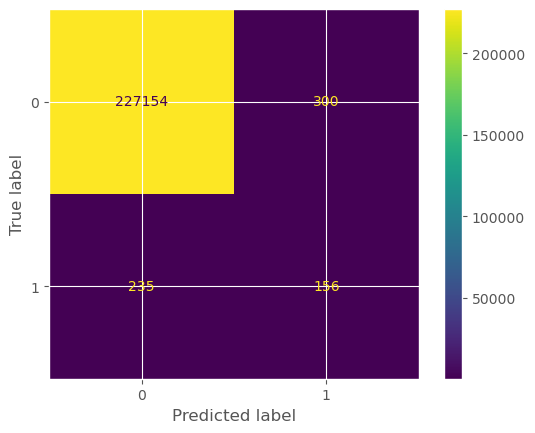

In [33]:
%%time
copod = COPOD(contamination=contamination)
copod.fit(X_train)
metrics(copod, y_train)

### ROD
Rotation-based Outlier Detection (ROD), is a robust and parameter-free algorithm that requires no statistical distribution assumptions and works intuitively in three-dimensional space, where the 3D-vectors, representing the data points, are rotated about the geometric median two times counterclockwise using Rodrigues rotation formula. The results of the rotation are parallelepipeds where their volumes are mathematically analyzed as cost functions and used to calculate the Median Absolute Deviations to obtain the outlying score. For high dimensions > 3, the overall score is calculated by taking the average of the overall 3D-subspaces scores, that were resulted from decomposing the original data space

In [34]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.3)

train size: 85442
contamination: 0.002 (0.2%)


In [35]:
# %%time
# rod = ROD(contamination=contamination)
# rod.fit(X_train)
# metrics(rod, y_train)

ROD работает слишком долго даже на 30% данных...

### Deep SVD
Deep One-Class Classifier with AutoEncoder (AE) is a type of neural networks for learning useful data representations in an unsupervised way. DeepSVDD trains a neural network while minimizing the volume of a hypersphere that encloses the network representations of the data, forcing the network to extract the common factors of variation. Similar to PCA, DeepSVDD could be used to detect outlying objects in the data by calculating the distance from center

In [36]:
from pyod.models.deep_svdd import DeepSVDD

In [37]:
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.1)

train size: 28480
contamination: 0.002 (0.2%)


In [38]:
def objective(trial):
    neurons = X_train.shape[1]
    clf = DeepSVDD(
        random_state=0,
        contamination=contamination,
        verbose=0,
        hidden_neurons=[neurons, round(neurons / 2)],
        use_ae=trial.suggest_categorical('use_ae', [True, False]),
        epochs=trial.suggest_int('epochs', 100, 300),
        dropout_rate=trial.suggest_float('dropout', 0.05, 0.5, log=True),
        l2_regularizer=trial.suggest_float('l2', 0.05, 0.5, log=True)
    )
    clf.fit(X_train)
    y_pred = clf.labels_
    return average_precision_score(y_train, y_pred)

[I 2023-08-01 22:13:03,118] A new study created in memory with name: no-name-68698e05-5dc7-4c10-b5a3-4cc366b01150


  0%|          | 0/20 [00:00<?, ?it/s]

890/890 [==============================] - 1s 1ms/step
[I 2023-08-01 22:17:27,409] Trial 0 finished with value: 0.0017907303370786516 and parameters: {'use_ae': False, 'epochs': 224, 'dropout': 0.08440345591140104, 'l2': 0.2834954516507964}. Best is trial 0 with value: 0.0017907303370786516.
890/890 [==============================] - 1s 1ms/step
[I 2023-08-01 22:24:53,751] Trial 1 finished with value: 0.27050142671892335 and parameters: {'use_ae': True, 'epochs': 292, 'dropout': 0.21565989598129934, 'l2': 0.12681717418496338}. Best is trial 1 with value: 0.27050142671892335.
890/890 [==============================] - 1s 1ms/step
[I 2023-08-01 22:30:50,986] Trial 2 finished with value: 0.1829576902710621 and parameters: {'use_ae': False, 'epochs': 295, 'dropout': 0.4978214914763344, 'l2': 0.2072124444461454}. Best is trial 1 with value: 0.27050142671892335.
890/890 [==============================] - 1s 1ms/step
[I 2023-08-01 22:35:23,392] Trial 3 finished with value: 0.00715423686722865

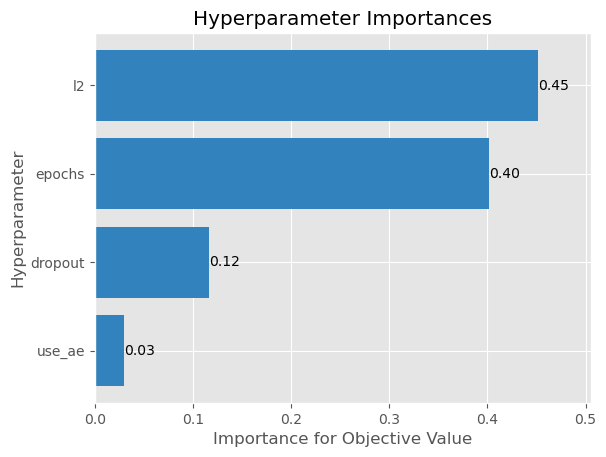

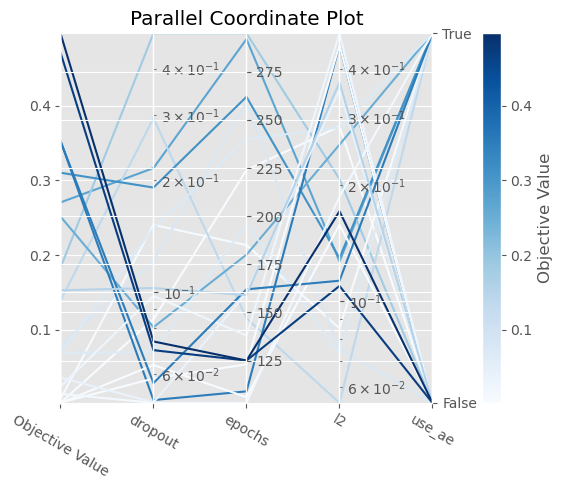

In [39]:
optimize(objective, 20)